In [1]:
import boto3
import json
from datetime import datetime
from edc import setup_environment_variables

# Oauth
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:
* `SH_CLIENT_NAME`
* `SH_CLIENT_SECRET`
* `SH_INSTANCE_ID`
* `SH_CLIENT_ID`

The following additional environment variables have been loaded from `~/custom.env`:
* `AWS_BUCKET`
------


In [2]:
# Your client credentials
client_id = %env SH_CLIENT_ID
client_secret = %env SH_CLIENT_SECRET

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)

resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

url = 'https://services.sentinel-hub.com/batch/v1/process/'

In [3]:
bucket_name = %env AWS_BUCKET

In [4]:
i = 0

s3 = boto3.resource('s3')
bk = s3.Bucket(bucket_name)

objects = list(bk.objects.all())
request_ids = set([o.key.split('/')[0] for o in objects if '/' in o.key])

for rid in request_ids:
    # Check if measurements.json already exists for a request
    if f'{rid}/measurements.json' in [o.key for o in objects]:
        pass
    else:
        response = oauth.request('GET', f'{url}{rid}')

        if response.ok:
            request = response.json()

            if request['status'] == 'DONE':
                # Collect size
                size = sum([o.size for o in objects if o.key.startswith(rid)])
                
                # Collect execution time
                created = datetime.fromisoformat(request['created'].replace('Z','+00:00'))
                finished = max([o.last_modified for o in objects if o.key.startswith(rid) and
                               o.key.endswith('tif')])
                
                # Collect costs
                tiles = []
                viewtoken = 0
                while viewtoken is not None:
                    response = oauth.request('GET', f'{url}{rid}/tiles?viewtoken={viewtoken}').json()
                    tiles.extend(response['member'])
                    viewtoken=response['view']['nextToken']
                costs = sum([t['cost'] for t in tiles])

                # Save measurements to bucket
                bk.put_object(Key=rid + '/measurements.json', Body=json.dumps({
                    'description': request['description'],
                    'id': rid,
                    'execution time': str(finished-created),
                    'costs': costs,
                    'n_tiles': len(tiles),
                    'n_timeslices': len(json.load(bk.Object(key=f'{rid}/userdata.json').get()['Body'])['time']),
                    'size': size
                }))
                
                i+=1


print(i, 'measurements written to bucket')

0 measurements written to bucket


In [5]:
import pandas as pd
objects = list(bk.objects.all())
df= pd.DataFrame([json.load(o.get()['Body']) for o in objects if o.key.endswith('measurements.json')])
df['size'] = df['size'] /2**30 #GiB
df[df.description == 'Test MAB'].sort_values('n_timeslices')

,description,id,execution time,costs,size,n_tiles,n_timeslices
126,Test MAB,cb56bf1d-8dbb-405b-b24b-d024ab6613ec,0:16:54.499000,53171.563823,13.278564,57.0,4.0
77,Test MAB,801bdcc7-ec03-4bac-8c4b-b947b61e2945,0:26:11.840000,82917.462226,18.617208,57.0,6.0
70,Test MAB,777c0ee9-c2b8-4fea-b585-69bae11322ab,0:34:55.094000,113603.476756,24.080159,57.0,8.0
73,Test MAB,789bb20c-2074-4c5b-ba7b-35a0d12440ea,0:43:50.979000,147444.536613,29.590905,57.0,10.0
2,Test MAB,0af8bd9f-95fb-48db-bba6-3338951690ab,0:51:35.152000,174327.956949,34.839634,57.0,12.0


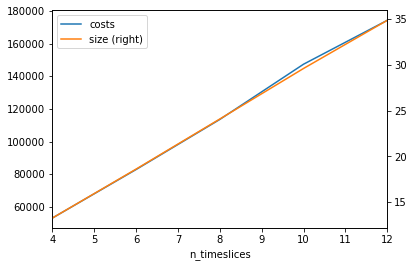

In [6]:
df_mab = df[df.description == 'Test MAB']
df_mab.loc[:, df_mab.columns != 'n_tiles'].sort_values('n_timeslices').plot(x='n_timeslices', secondary_y='size')

In [7]:
import statsmodels.formula.api as sm

In [8]:
res = df_mab.pipe((sm.ols, 'data'), 'costs ~ n_timeslices').fit()
params = res.params
(params.Intercept + params.n_timeslices * 30) *266/57 # Austria has 266 tiles

2108478.614557192